In [60]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from datetime import datetime, timedelta
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [61]:
df = pd.read_csv('D:\\ML PROJECTS\\AML lab\\dataset\\HistoricalQuotes.csv')

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         2518 non-null   object
 1    Close/Last  2518 non-null   object
 2    Volume      2518 non-null   int64 
 3    Open        2518 non-null   object
 4    High        2518 non-null   object
 5    Low         2518 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.2+ KB


In [63]:
# Check exact column names
print("Column names:")
print(df.columns.tolist())

# Check for any extra spaces
print("\nColumn names with quotes to see spaces:")
for col in df.columns:
    print(f"'{col}'")

Column names:
['Date', ' Close/Last', ' Volume', ' Open', ' High', ' Low']

Column names with quotes to see spaces:
'Date'
' Close/Last'
' Volume'
' Open'
' High'
' Low'


In [64]:
# Fix column names first (remove leading/trailing spaces)
df.columns = df.columns.str.strip()

# Now convert to numeric
df['Close/Last'] = pd.to_numeric(df['Close/Last'].str.replace('$', ''))
df['Open'] = pd.to_numeric(df['Open'].str.replace('$', ''))
df['High'] = pd.to_numeric(df['High'].str.replace('$', ''))
df['Low'] = pd.to_numeric(df['Low'].str.replace('$', ''))
df['Date'] = pd.to_datetime(df['Date'])


In [65]:
print("Column names:")
print(df.columns.tolist())

Column names:
['Date', 'Close/Last', 'Volume', 'Open', 'High', 'Low']


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              2518 non-null   datetime64[ns]
 1   Close/Last        2518 non-null   float64       
 2   Volume            2518 non-null   int64         
 3   Open              2518 non-null   float64       
 4   High              2518 non-null   float64       
 5   Low               2518 non-null   float64       
 6   Price_Up          2518 non-null   int32         
 7   Price_Range       2518 non-null   float64       
 8   Price_Change      2518 non-null   float64       
 9   Price_Change_Pct  2518 non-null   float64       
 10  Volume_MA_5       2514 non-null   float64       
 11  Close_MA_5        2514 non-null   float64       
 12  Volume_Above_Avg  2518 non-null   int32         
dtypes: datetime64[ns](1), float64(9), int32(2), int64(1)
memory usage: 236.2 KB


In [67]:
import pandas as pd

# Function to clean and convert price columns
def clean_price_column(column):
    if column.dtype == 'object':
        # If it's object type, try to clean it
        return pd.to_numeric(column.astype(str).str.replace('$', '').str.replace(',', ''))
    else:
        # If it's already numeric, return as is
        return column

# Apply to price columns
df['Close/Last'] = clean_price_column(df['Close/Last'])
df['Open'] = clean_price_column(df['Open'])
df['High'] = clean_price_column(df['High'])
df['Low'] = clean_price_column(df['Low'])
df['Date'] = pd.to_datetime(df['Date'])

In [68]:
print("After conversion:")
print(df.dtypes)
print(df.head())

After conversion:
Date          datetime64[ns]
Close/Last           float64
Volume                 int64
Open                 float64
High                 float64
Low                  float64
dtype: object
        Date  Close/Last     Volume    Open    High     Low
0 2020-02-28      273.36  106721200  257.26  278.41  256.37
1 2020-02-27      273.52   80151380  281.10  286.00  272.96
2 2020-02-26      292.65   49678430  286.53  297.88  286.50
3 2020-02-25      288.08   57668360  300.95  302.53  286.13
4 2020-02-24      298.18   55548830  297.26  304.18  289.23


In [69]:
# Create target variable (e.g., price direction - will stock go up next day?)
df['Price_Up'] = (df['Close/Last'].shift(-1) > df['Close/Last']).astype(int)

# Create additional features
df['Price_Range'] = df['High'] - df['Low']
df['Price_Change'] = df['Close/Last'] - df['Open']
df['Price_Change_Pct'] = ((df['Close/Last'] - df['Open']) / df['Open']) * 100
df['Volume_MA_5'] = df['Volume'].rolling(window=5).mean()
df['Close_MA_5'] = df['Close/Last'].rolling(window=5).mean()
df['Volume_Above_Avg'] = (df['Volume'] > df['Volume_MA_5']).astype(int)

# Check the new features
print("New features created:")
print(df[['Date', 'Close/Last', 'Price_Up', 'Price_Range', 'Price_Change', 'Volume_MA_5']].head(10))

New features created:
        Date  Close/Last  Price_Up  Price_Range  Price_Change  Volume_MA_5
0 2020-02-28      273.36         1        22.04         16.10          NaN
1 2020-02-27      273.52         1        13.04         -7.58          NaN
2 2020-02-26      292.65         0        11.38          6.12          NaN
3 2020-02-25      288.08         1        16.40        -12.87          NaN
4 2020-02-24      298.18         1        14.95          0.92   69953640.0
5 2020-02-21      313.05         1         9.95         -5.57   55094684.0
6 2020-02-20      320.30         1         6.44         -2.33   44092706.0
7 2020-02-19      323.62         0         4.57          3.62   38856218.0
8 2020-02-18      319.00         1         5.14          3.64   34960656.0
9 2020-02-14      324.95         0         3.13          0.21   27856580.0


In [70]:
# Select features for the model
feature_columns = ['Volume', 'Price_Range', 'Price_Change', 'Price_Change_Pct', 'Volume_MA_5', 'Volume_Above_Avg']

# Remove rows with NaN values (due to rolling averages and shifts)
df_clean = df.dropna()

X = df_clean[feature_columns]
y = df_clean['Price_Up']

print(f"Dataset shape: {X.shape}")
print(f"Target distribution:")
print(y.value_counts())

Dataset shape: (2514, 6)
Target distribution:
Price_Up
0    1332
1    1182
Name: count, dtype: int64


In [71]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8270

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       267
           1       0.83      0.79      0.81       236

    accuracy                           0.83       503
   macro avg       0.83      0.83      0.83       503
weighted avg       0.83      0.83      0.83       503


Confusion Matrix:
[[229  38]
 [ 49 187]]


In [72]:
# Get feature importance (coefficients)
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'coefficient': model.coef_[0],
    'abs_coefficient': abs(model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("Feature Importance:")
print(feature_importance)

# Show some predictions with probabilities
results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred,
    'Probability': y_pred_proba
}).head(10)

print("\nSample Predictions:")
print(results_df)

Feature Importance:
            feature  coefficient  abs_coefficient
3  Price_Change_Pct    -2.001839         2.001839
2      Price_Change    -0.936801         0.936801
1       Price_Range     0.377739         0.377739
0            Volume     0.054065         0.054065
5  Volume_Above_Avg    -0.051708         0.051708
4       Volume_MA_5    -0.021862         0.021862

Sample Predictions:
   Actual  Predicted  Probability
0       1          1     0.962132
1       1          1     0.761882
2       1          1     0.913239
3       1          1     0.623813
4       1          1     0.602739
5       0          0     0.308557
6       1          0     0.380055
7       1          1     0.729258
8       0          0     0.028868
9       1          1     0.979649


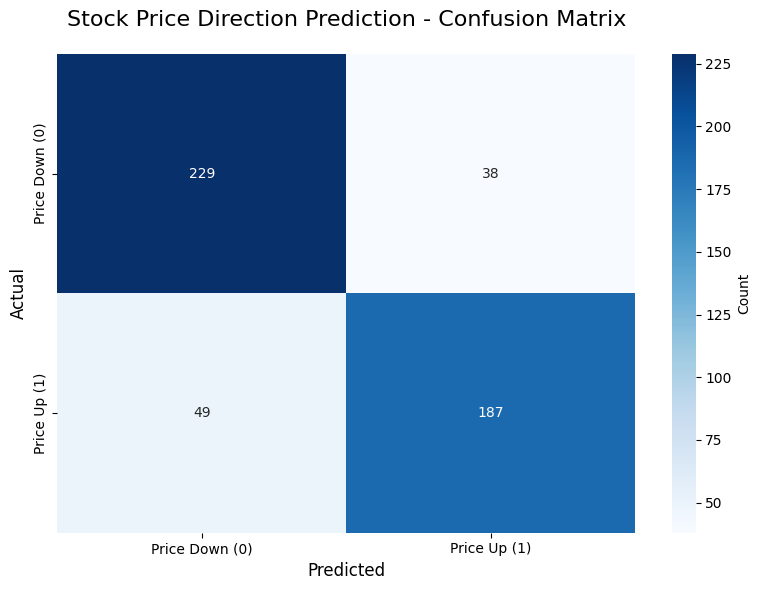


Confusion Matrix Breakdown:
True Negatives (TN): 229
False Positives (FP): 38
False Negatives (FN): 49
True Positives (TP): 187

Additional Metrics:
Precision: 0.8311
Recall (Sensitivity): 0.7924
Specificity: 0.8577


In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Create confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Price Down (0)', 'Price Up (1)'],
                yticklabels=['Price Down (0)', 'Price Up (1)'],
                cbar_kws={'label': 'Count'})
    
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Print additional metrics
    tn, fp, fn, tp = cm.ravel()
    print(f"\nConfusion Matrix Breakdown:")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")
    
    # Calculate additional metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"\nAdditional Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")

# Call the function
plot_confusion_matrix(y_test, y_pred, 'Stock Price Direction Prediction - Confusion Matrix')

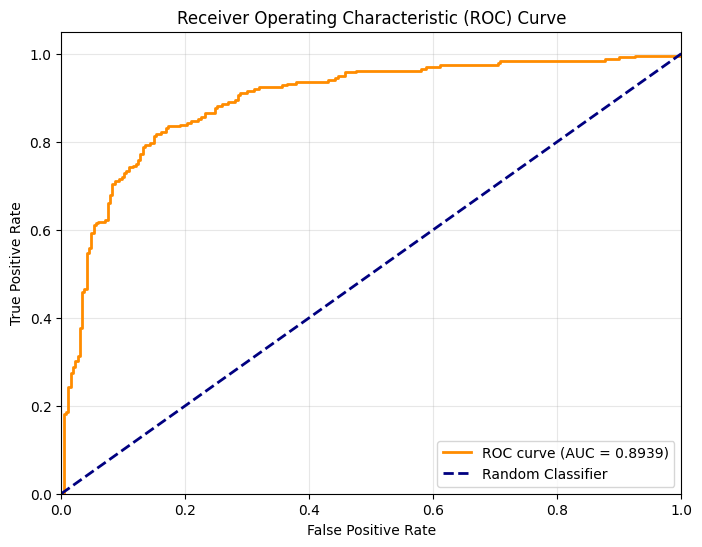

AUC Score: 0.8939


In [74]:
#ROC and AUC curve
from sklearn.metrics import roc_curve, auc, roc_auc_score

def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"AUC Score: {roc_auc:.4f}")

plot_roc_curve(y_test, y_pred_proba)

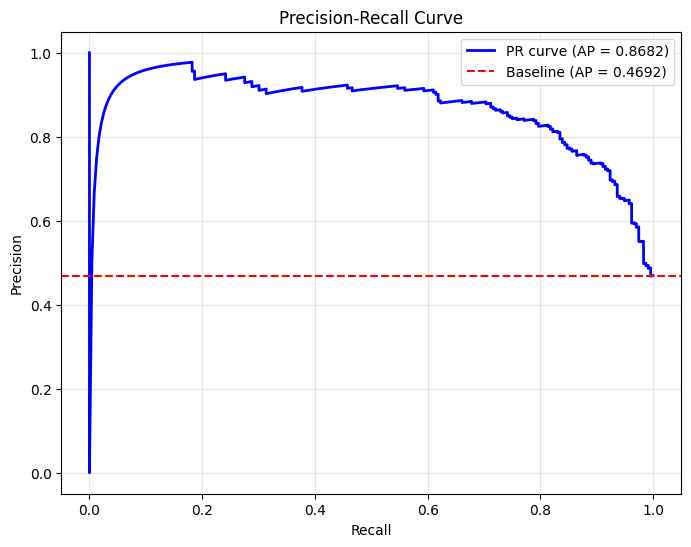

Average Precision Score: 0.8682


In [75]:
#precision recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(y_true, y_pred_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    avg_precision = average_precision_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.4f})')
    plt.axhline(y=y_true.mean(), color='red', linestyle='--', label=f'Baseline (AP = {y_true.mean():.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Average Precision Score: {avg_precision:.4f}")

plot_precision_recall_curve(y_test, y_pred_proba)

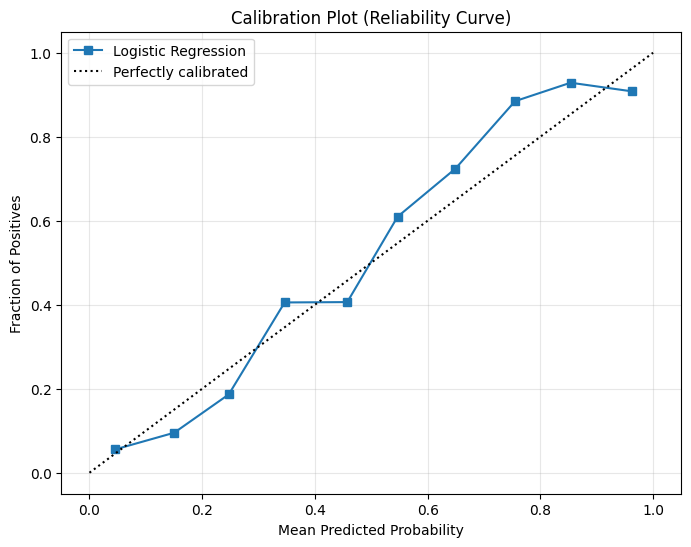

In [76]:
#Caliberation Plot (Reliability Plot    )
from sklearn.calibration import calibration_curve

def plot_calibration_curve(y_true, y_pred_proba, n_bins=10):
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_pred_proba, n_bins=n_bins)
    
    plt.figure(figsize=(8, 6))
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Logistic Regression")
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Plot (Reliability Curve)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_calibration_curve(y_test, y_pred_proba)

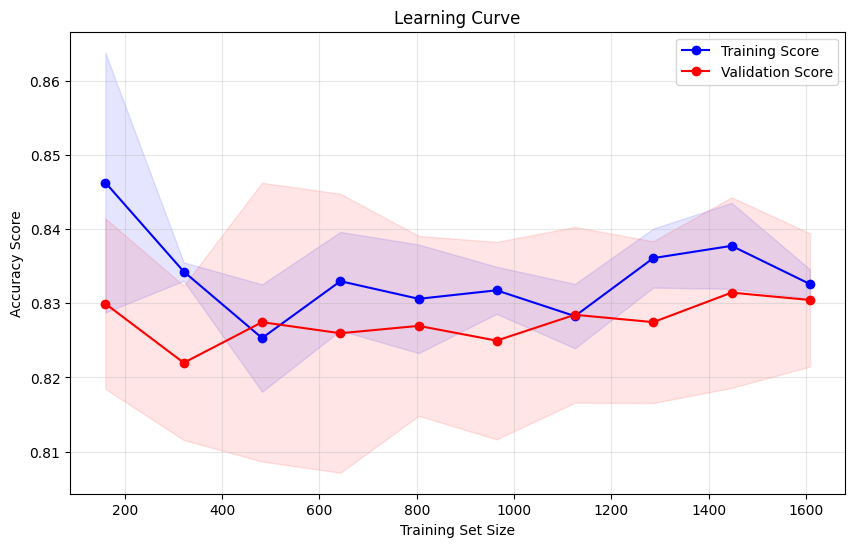

In [77]:
# Learning Curve 
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, cv=5):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    
    plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
    
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy Score')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_learning_curve(model, X_train_scaled, y_train)

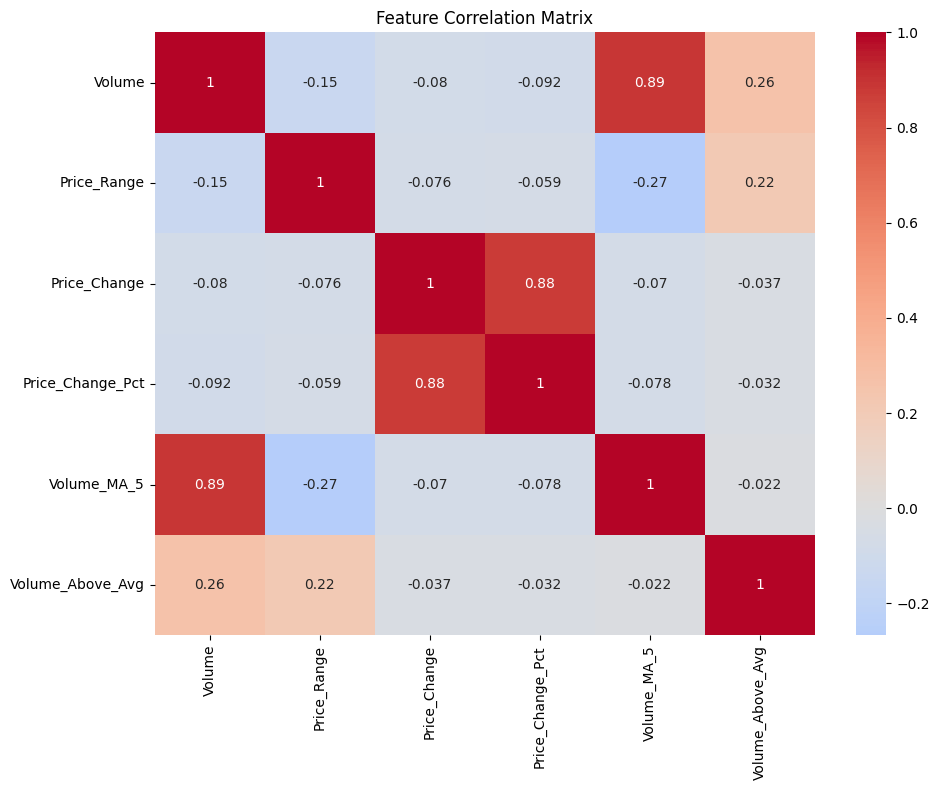

In [78]:
# Feature Collection heatmap
def plot_feature_correlation(X, feature_names):
    plt.figure(figsize=(10, 8))
    correlation_matrix = np.corrcoef(X.T)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                xticklabels=feature_names, yticklabels=feature_names)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

plot_feature_correlation(X_train_scaled, feature_columns)

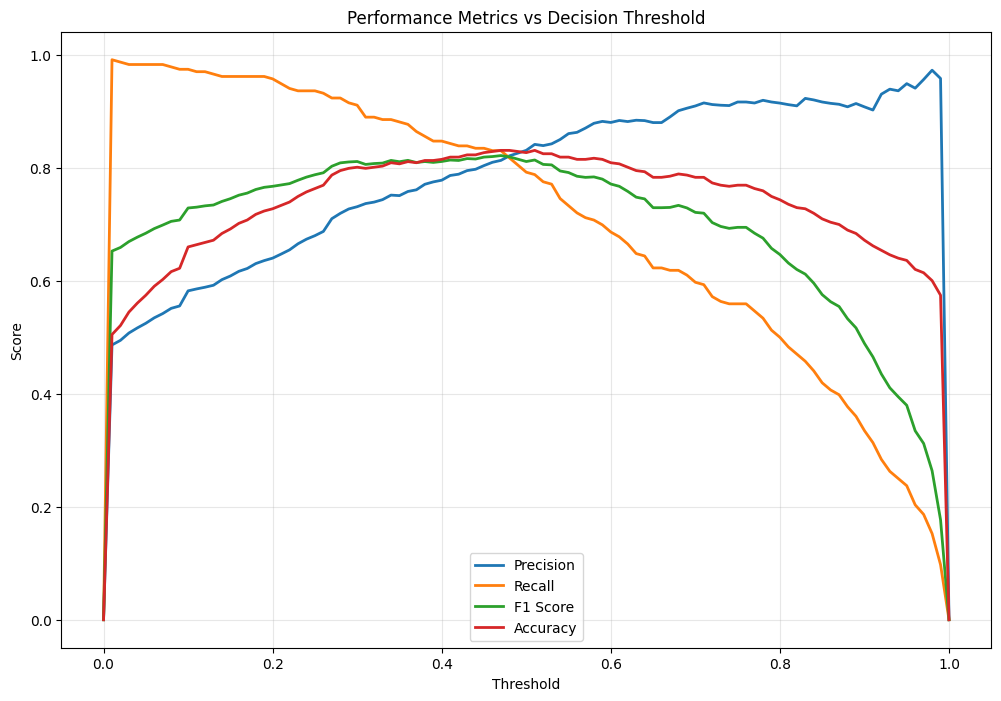

Optimal threshold for F1 score: 0.470
F1 score at optimal threshold: 0.8218


In [79]:
def plot_threshold_analysis(y_true, y_pred_proba):
    thresholds = np.linspace(0, 1, 101)
    precisions, recalls, f1_scores, accuracies = [], [], [], []
    
    for threshold in thresholds:
        y_pred_thresh = (y_pred_proba >= threshold).astype(int)
        
        if len(np.unique(y_pred_thresh)) > 1:
            precision = precision_score(y_true, y_pred_thresh)
            recall = recall_score(y_true, y_pred_thresh)
            f1 = f1_score(y_true, y_pred_thresh)
            accuracy = accuracy_score(y_true, y_pred_thresh)
        else:
            precision = recall = f1 = accuracy = 0
            
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        accuracies.append(accuracy)
    
    plt.figure(figsize=(12, 8))
    plt.plot(thresholds, precisions, label='Precision', linewidth=2)
    plt.plot(thresholds, recalls, label='Recall', linewidth=2)
    plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=2)
    plt.plot(thresholds, accuracies, label='Accuracy', linewidth=2)
    
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Performance Metrics vs Decision Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Find optimal threshold for F1 score
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal threshold for F1 score: {optimal_threshold:.3f}")
    print(f"F1 score at optimal threshold: {f1_scores[optimal_idx]:.4f}")

from sklearn.metrics import precision_score, recall_score, f1_score
plot_threshold_analysis(y_test, y_pred_proba)

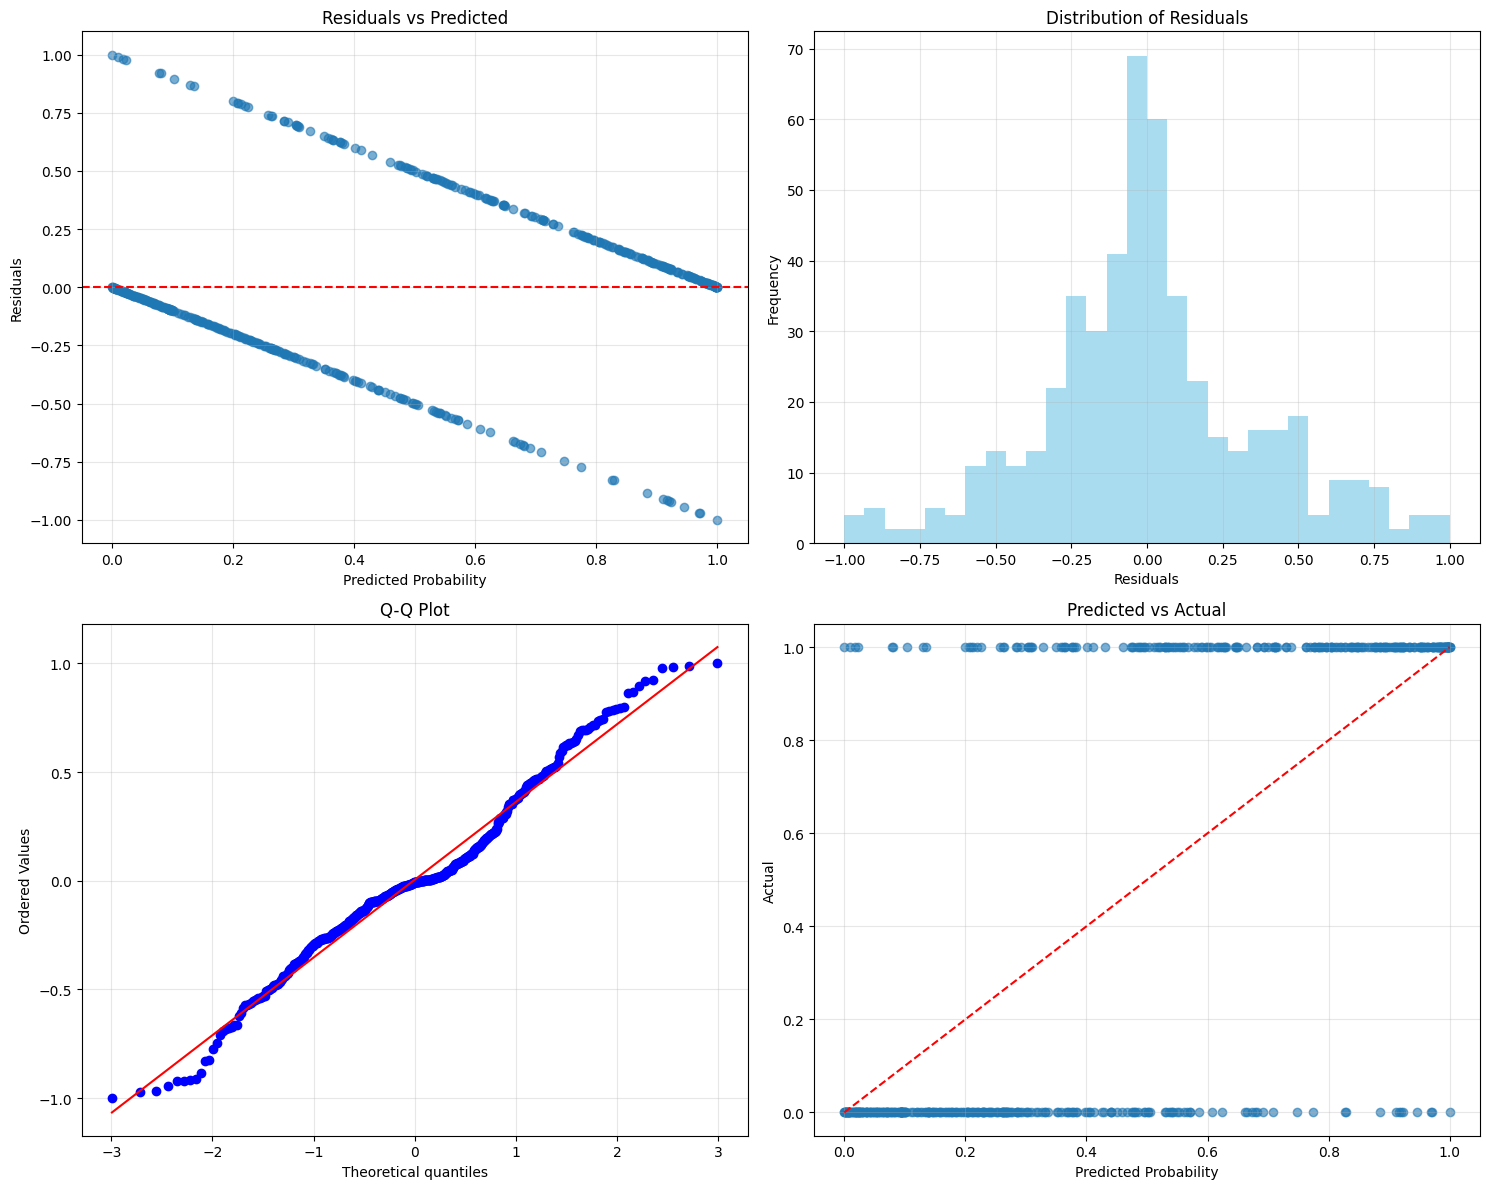

In [80]:
def plot_residual_analysis(y_true, y_pred_proba):
    residuals = y_true - y_pred_proba
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Residuals vs Predicted
    axes[0, 0].scatter(y_pred_proba, residuals, alpha=0.6)
    axes[0, 0].axhline(y=0, color='red', linestyle='--')
    axes[0, 0].set_xlabel('Predicted Probability')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Residuals vs Predicted')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Histogram of residuals
    axes[0, 1].hist(residuals, bins=30, alpha=0.7, color='skyblue')
    axes[0, 1].set_xlabel('Residuals')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of Residuals')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Q-Q plot
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Predicted vs Actual
    axes[1, 1].scatter(y_pred_proba, y_true, alpha=0.6)
    axes[1, 1].plot([0, 1], [0, 1], 'red', linestyle='--')
    axes[1, 1].set_xlabel('Predicted Probability')
    axes[1, 1].set_ylabel('Actual')
    axes[1, 1].set_title('Predicted vs Actual')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_residual_analysis(y_test, y_pred_proba)